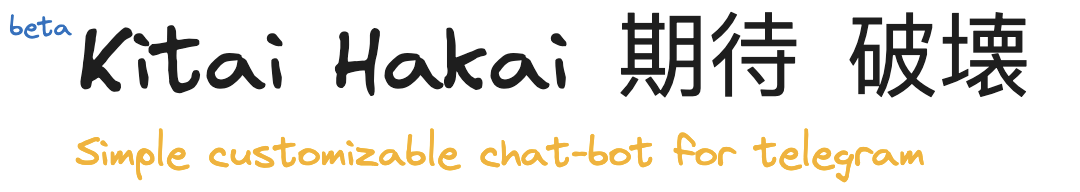

# Kitai Hakai 期待 破壊 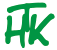 
### <span style="color:#fab005;">Simple customizable chatbot for Telegram powered by NLP approaches</span>
<hr>

#### Version: Beta 0.1.0
#### Author: Fabio Duarte Junior
#### Contact: fabiojr@skiffmail.com | Repo: https://github.com/FabioD-Junior/Kitai/

##### This code is supposed to run in a Jupyter Notebook environment. (You can easily adapt it to run in plain .py files)
##### The current version is based on the Levenshtein distance approach with an option to apply NLP pre-processing
##### plus a key/value message/response "database" file with the capacity to map custom functions.

### To-do
>- [ ] Insert an option for choosing the cosine distance as a measure to compare the matches

>- [ ] Prepare code for a database connection option

>- [ ] Create a user interface to manage the messages

>- [ ] Test the performance/"accuracy" differences between using RAW, NLP, and different distance thresholds

>- [ ] Add functionalities for keeping user preferences and languages

<br><br>
#### Please, before using this notebook, pay attention to these points:

<hr>
> <span style="color:red;">Despite of being functional, this project is a work in progress and could present errors.</span>

> <span style="color:red;">You are free to use this code, but you MUST give proper credit to the author, preferably using APA citation format.</span>

> <span style="color:red;">This project does not come with any guarantees of any kind. </span>

> <span style="color:red;">This project is done for academic and hobby reasons; it may contain errors, inaccuracies, inefficient code, etc. <b>Use at your own risk.</b></span>

> <span style="color:red;">Don't forget to check the repository's license section. </span>

> <span style="color:red;">Please check the specific licenses for each library individually before using this project. </span>

<hr>

#### Instructions on how to run this project
> In order to use this project, you need a Telegram bot token in advance.
> This project was tested using a dataset generated by A.I. (chat GPT) for testing purposes. You MUST tune the parameters in the parameter section
in order to make the ChatBot more accurate to your data.
> To get a Telegram bot token, you can log in to your Telegram account and look for @BotFather; it is an automation for bot management. 
> Say hi to BotFather and follow the instructions

> Originally, this notebook is followed by the CSV files generated for testing purposes; you should replace them with your message/response files.

> <b>Tip:</b> It should work with most languages in raw mode (NLP_MODE = False). For using NLP, you must download specific NLTK files.

> To install the required libraries, use the requirements.txt file or uncomment the lines in the related cell below.

###### Lib instalation

In [ ]:
## Requirements instalation / uncomment the lines bellow or refer to the requirements.txt file
#!pip install pyTelegramBotAPI
#!pip install Levenshtein
#!pip install install nltk

## <span style="color:#6A99D0;">00 - Libs</span>

In [ ]:
import Levenshtein
import random
import pandas as pd
import nltk
import telebot
from   telebot       import types
from   nltk.tokenize import word_tokenize
from   nltk.corpus   import stopwords
from   nltk.stem     import WordNetLemmatizer

## <span style="color:#6A99D0;">01 - Files and Global Variables</span>

### <span style="color:#6A99D0;">1.1 - Files</span>

In [ ]:
## Load all pair-wise message/response CSV files merging into a unique dataset

CSV_DIR ="EN"

def concatenate_CSV(directory):
    """ Concatenates the CSV files in the directory into a unique dataframe.
    Parameters:
        directory (str): Directory containing the message/response files as CSV, delimited by ';'.

    Returns:
        pd.DataFrame: Concatenated DataFrame with leading and trailing whitespaces removed.
    """
    # Lib imported for file manipulation purposes.
    import os
    
    # Create a list to hold the dataframes.
    dataframes = []

    # Iterate through the CSV files in the directory.
    for file in os.listdir(directory):
        if file.endswith(".csv"):    
            file_path = os.path.join(directory, file)                # Gets the full path           
            df = pd.read_csv(file_path, delimiter=';', comment='#')  # The delimiter must be ';'
            dataframes.append(df)                                    # Add to the dataframe list 
            
    # Concatenate all DataFrames into a unique dataset.
    final_df = pd.concat(dataframes, ignore_index=True)  
    
    # Remove leading and trailing whitespaces from all string columns.
    final_df = final_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

    return final_df

database = concatenate_CSV(CSV_DIR)

# Converting all the messages to lowercase
database['message'] =database['message'].apply(lambda x: x.lower())


In [ ]:
# Load error messages
error_responses = "en/09-error_messages.txt"

# Create a list to store error messages
error_messages = []

# Open the error_responses file and read its lines
with open(error_responses, 'r', encoding='utf-8') as file:
    error_messages = file.readlines()

In [ ]:
# NLTK files
nltk.download('punkt')     # pre-treined tokenizer for english language
nltk.download('wordnet')   # Lexical database for english language
nltk.download('stopwords') # Stopwords for english language

### <span style="color:#6A99D0;">1.2 - Global Variables and Configuration</span>

In [ ]:
# Global Variables
TOKEN = "<YOUR TELEGRAM BOT TOKEN HERE (ASK TO THE @BOTFATHER)>"

# General parameters - Please note that the parameters will directly affect how "accurate" the responses will be. 
NLP_MODE           = True    # Activate NLP pre-processing
RM_STOP_WORDS      = False    # Enable the process of removing stop words 
DISTANCE_THRESHOLD = 14      # Maximum Levenshtein distance to consider a correct match
USER_ID            = ""      # Stores the user ID for logging and session control purposes

## <span style="color:#6A99D0;">2.0 - Bot engine</span>

### <span style="color:#6A99D0;">2.1 - Creating the bot Object</span>

In [ ]:
bot = telebot.TeleBot(TOKEN,threaded=True)

### <span style="color:#6A99D0;">2.2 - Main Functions </span>

In [ ]:
@bot.message_handler(commands=['start'])
def welcome(message):
    
    # Set welcome message and options to start/stop the bot (you can customize it for our own menu)
    markup = types.ReplyKeyboardMarkup(row_width=2)
    itembtn1 = types.KeyboardButton('/start')
    itembtn2 = types.KeyboardButton('/stop')
    markup.add(itembtn1, itembtn2)
    global USER_ID
    USER_ID = str(message.from_user.id)
    bot.send_message(message.chat.id, "Welcome to Kitai!", reply_markup=markup)

@bot.message_handler(func=lambda message: True)
def process_inputs(message):
    
    # Obtaining the id of the user, for session control/log purposes
    global USER_ID   # In order to updated the current user id.
    USER_ID = str(message.from_user.id)
    
    # Apply NLP pre-processing in the input message
    if NLP_MODE: 
        message.text = pre_process(str(message.text).lower())
        
    # Encontrar a chave mais semelhante no dicionário
    closest_match = min(responses.keys(), key=lambda x: Levenshtein.distance(x, str(message.text).lower()))
    
    # if the distance is greater the maximum consider that the bot could not understand the message
    if DISTANCE_THRESHOLD < Levenshtein.distance(closest_match, str(message.text).lower()):
        closest_match =""
    
    # Get the closest match or a random error message
    response = responses.get(closest_match, random.choice(error_messages))

    # Handle mapped functions for specific commands treatment  
    if response in function_map:
        function_map[response](message) # In case the response be a mapped function it will be executed instead of the 
    else:
        bot.reply_to(message, response)

## Functions for log
def write_log(message):
    try:
        # Open the log file in append mode ('a')
        with open('log.txt', 'a') as log_file:      
            log_file.write(f'{get_current_date_time()}: {message}\n') # Write the log message with the current date and time
    except Exception as e:
        log_error(f'Error writing to the log file: {str(e)}')         # In case of an error, log the exception

def get_current_date_time():
    from datetime import datetime
    return datetime.now().strftime('%Y-%m-%d %H:%M:%S')        

### <span style="color:#6A99D0;">2.3 - Auxiliary and Custom Functions</span>

In [ ]:
# Define custom function
def reply_time(message):
    bot.reply_to(message, get_current_date_time())
    
def reply_weather(message):
    weather_list =["good","bad","sunny","rainy","cloudy","snowy"]
    bot.reply_to(message, "I'll guess it might be a " + random.choice(weather_list) +" weather today.(but it is just a guess)")
    
# Maps custom functions. 
# The key Must be associated with the responses in file 10-specific_commands

function_map = {
    "func_time"   : reply_time,
    "func_weather": reply_weather
}

### <span style="color:#6A99D0;">2.4 - Preparing the data </span>

In [ ]:
# If NLP pre-processing is enabled it will use the above functions to prepare the data.

def pre_process(text):
    """Pre-process the text by 1 - tokenizing, 2 - remove stop words, 3 - lemmatization
       Input  - text(string)
       output - lemmatized text (string)
    """     
    # Ensuring the input is a string
    text = str(text)
    
    
    # 01 - Tokenizing
    tokens = word_tokenize(text)
 
    # 02 - Removing the stopwords
    if RM_STOP_WORDS:
        stop_words = set(stopwords.words('english'))                      
        tokens     = [token for token in tokens if token.lower() not in stop_words]
    
    # 03 - lemmatizing 
    lemmatizer        = WordNetLemmatizer()                                # Instancing the lemmatizer
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize each word token 
    lemmatized_text   = ' '.join(lemmatized_tokens)                        # Getting lemmatized tokens back into a single string 
    
    # Returning the lemmatized text as a single string
    return lemmatized_text

In [ ]:
# Handle NLP-pre processing
if NLP_MODE:        
    database['lemmatized_message'] = database['message'].apply(pre_process)

## Message/Response "Database" to dict
responses = dict(zip(database['message'], database['response']))


### <span style="color:#6A99D0;">2.4 - Instantiating and running the bot </span>

In [ ]:
try:
    write_log("Bot started with the following parameter :User [ " + str(USER_ID) 
              + "] NLP mode :"        + str(NLP_MODE) 
              + " Maximum Distance :" + str(DISTANCE_THRESHOLD))
    
    # Start listenning for messages
    bot.polling()
    
except Exception as e:
    print("An error occured during the execution:", str(e))
    write_log(  "Error"               + str(e) 
              + "Parameters:User [ "  + str(USER_ID) 
              + "] NLP mode :"        + str(NLP_MODE) 
              + " Maximum Distance :" + str(DISTANCE_THRESHOLD))
    
finally:
    write_log(  "End of bot execution :User [ " + str(USER_ID) 
              + "] NLP mode :"                  + str(NLP_MODE) 
              + " Maximum Distance :"           + str(DISTANCE_THRESHOLD))

##### Please remember that this project come as is, without any guarantee or support of any kind. Use it at your own risk.